In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [82]:
import numpy as np
import altair as alt
import pandas as pd

from scipy.sparse import lil_matrix
from annoy import AnnoyIndex
from collections import defaultdict
from titlecase import titlecase

from sklearn.decomposition import TruncatedSVD
from sklearn import manifold
from sklearn.decomposition import PCA

from sqlalchemy.dialects.postgresql import array_agg
from sqlalchemy.sql import functions as func

from osp_graphs.v1_db import session, Text, Field, Subfield, SubfieldDocument, Citation, Document

In [66]:
count = func.count(Citation.text_id)

res = (session
    .query(Text.surname, Text.title, array_agg(Citation.document_id))
    .join(Citation)
    .filter(Text.valid==True)
    .filter(Text.display==True)
    .group_by(Text.id)
    .order_by(count.desc())
    .limit(1000)
    .all())

In [67]:
surname_docs = defaultdict(set)
surname_titles = defaultdict(set)

for surname, title, doc_ids in res:
    key = surname.strip('.,').lower()
    surname_docs[key].update(doc_ids)
    surname_titles[key].add(title)

In [68]:
surnames = sorted(surname_docs.keys())
surname_to_idx = {s: i for i, s in enumerate(surnames)}

In [69]:
doc_ids = list(set([did for _, _, doc_ids in res for did in doc_ids]))
doc_id_to_idx = {did: i for i, did in enumerate(doc_ids)}

In [70]:
sdm = np.zeros((len(doc_ids), len(surnames)))

for surname in surnames:
    sidx = surname_to_idx[surname]
    for doc_id in surname_docs[surname]:
        didx = doc_id_to_idx[doc_id]
        sdm[didx][sidx] += 1

In [71]:
sdm.sum()

495788.0

In [72]:
svd = TruncatedSVD(n_components=20)

In [73]:
svd.fit(sdm)

TruncatedSVD(algorithm='randomized', n_components=20, n_iter=5,
       random_state=None, tol=0.0)

In [74]:
svd.components_.T.shape

(642, 20)

In [75]:
dr = manifold.TSNE(n_components=2, init='pca')

In [76]:
dr.fit_transform(svd.components_.T)

array([[-18.208155  ,  -1.5115361 ],
       [-23.347324  ,  13.808158  ],
       [ -0.57253265,  -9.990682  ],
       ...,
       [  7.3714814 , -16.15266   ],
       [  3.0228186 ,  -1.2396349 ],
       [  3.6066015 ,   4.0972533 ]], dtype=float32)

In [83]:
rows = []
for surname, (x, y) in zip(surnames, dr.embedding_):
    rows.append(dict(surname=surname, titles=surname_titles[surname], x=x, y=y))

In [84]:
df = pd.DataFrame(rows)

In [85]:
df.surname = df.surname.apply(lambda s: s.capitalize())

In [86]:
df.titles = df.titles.apply(lambda ts: ', '.join([titlecase(t.strip(' /;.')) for t in ts]))

In [87]:
df

,surname,titles,x,y
0,Abrams,"A Glossary of Literary Terms, The Norton Antho...",-18.208155,-1.511536
1,Achebe,Things Fall Apart,-23.347324,13.808158
2,Addams,Twenty Years at Hull-House,-0.572533,-9.990682
3,Adorno,The Culture Industry,26.322136,-17.946905
4,Aeschylus,"Eumenides, The Libation Bearers, Agamemnon,, T...",3.989676,22.141012
5,Aesop,Fables,1.893125,14.515541
6,Alberts,"Essential Cell Biology, Molecular Biology of t...",-14.989966,-22.832966
7,Alcott,Little Women,-18.085789,13.004314
8,Alexie,The Lone Ranger and Tonto Fistfight in Heaven,-11.421200,14.398569
9,Allen,Without Feathers,-54.944508,13.733766


In [88]:
chart = (alt
    .Chart(df, width=1000, height=700)
    .mark_circle()
    .encode(x='x', y='y', tooltip='titles')
    .mark_text()
    .encode(text='surname'))

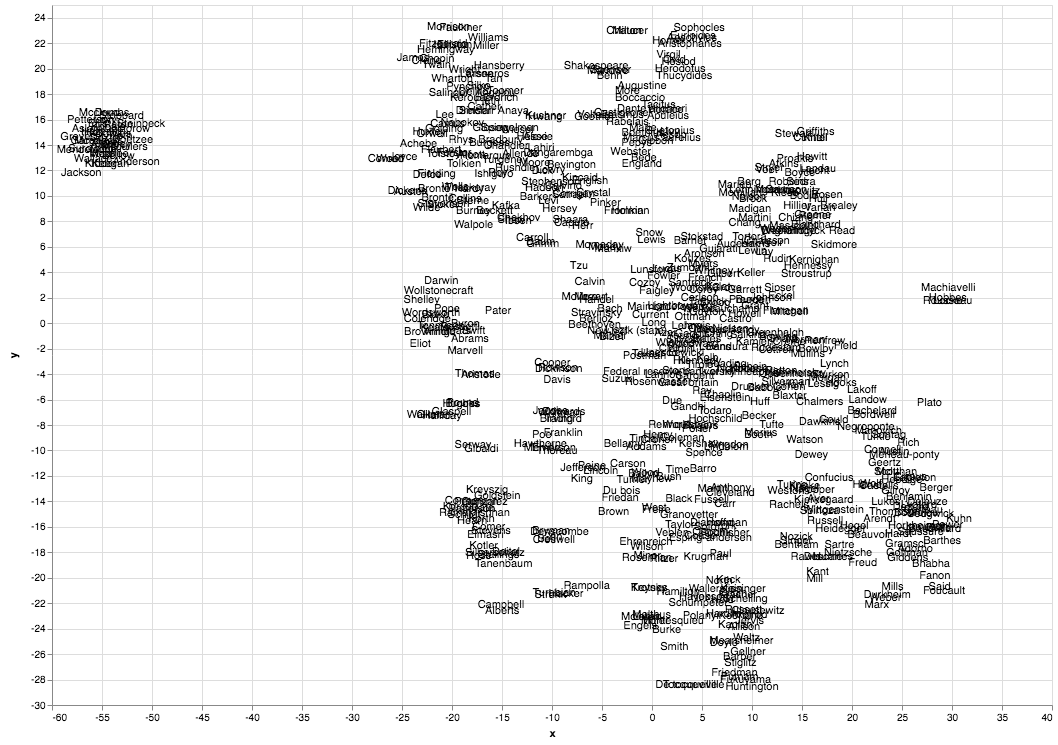

In [89]:
chart.interactive()